In [39]:
%load_ext autoreload
%autoreload 2

In [40]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
import os
import pandas as pd
from divexplorer_generalized.FP_Divergence import FP_Divergence

# Import data

In [42]:
dataset_name = 'wine'


In [43]:

df_all = []

for d in ['winequality-white', 'winequality-white']:
    df = pd.read_csv(f"https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/{d}.csv", sep=";")

    df["quality"] = df["quality"].apply(lambda x: "good" if x>5 else "bad")
    class_map = {'P': 'good', 'N': 'bad'}
    df.rename(columns = {"quality": "class"}, inplace=True)
    df_all.append(df)
    
df = pd.concat(df_all)
df.reset_index(drop=True, inplace = True)

# Train and predict with RF classifier

In [44]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier


attributes = df.columns.drop("class")
X = df[attributes].copy()
y = df["class"].copy()

clf = RandomForestClassifier(random_state=42)


k_cv = 10


cv = StratifiedKFold(n_splits=k_cv, random_state=42, shuffle=True
            )  # Added to fix the random state  #Added shuffle=True for new version sklearn, Value Error
       
y_predicted = cross_val_predict(clf, X, y.values, cv=cv)

In [7]:
df["predicted"] = y_predicted

In [45]:
df.shape[0]*0.02

195.92000000000002

# Tree divergence

In [9]:
true_class_name = "class"
pred_class_name = "predicted"
cols_c = [true_class_name, pred_class_name]

In [10]:
continuous_attributes = list(df.describe().columns)

In [11]:
df_analyze = df.copy()

In [12]:
min_support_tree = 0.1

In [13]:
metric = "d_fpr"

In [14]:
type_criterion="divergence_criterion"

type_experiment = "one_at_time"

In [15]:
from tree_discretization import TreeDiscretization

tree_discr = TreeDiscretization()

# ## Extract tree
generalization_dict, discretizations = tree_discr.get_tree_discretization(
    df_analyze,
    type_splitting=type_experiment,
    min_support=min_support_tree,
    metric=metric,
    class_map=class_map,
    continuous_attributes=list(continuous_attributes),
    class_and_pred_names=cols_c,
    storeTree=True,
    type_criterion=type_criterion, #entropy
    #minimal_gain = 0.0015
)

In [16]:
tree_discr.printDiscretizationTrees(round_v =2, show_condition = True)

fixed acidity
 root s=1.00 --> d_fpr=0.00
         fixed acidity<=6.8 s=0.54 --> d_fpr=-0.01
                 fixed acidity<=6.3 s=0.26 --> d_fpr=0.01
                         fixed acidity<=6.0 s=0.15 --> d_fpr=0.02
                         fixed acidity>6.0 s=0.11 --> d_fpr=-0.00
                 fixed acidity>6.3 s=0.27 --> d_fpr=-0.02
                         fixed acidity<=6.6 s=0.16 --> d_fpr=-0.02
                         fixed acidity>6.6 s=0.11 --> d_fpr=-0.01
         fixed acidity>6.8 s=0.46 --> d_fpr=0.01
                 fixed acidity<=7.4 s=0.26 --> d_fpr=0.01
                         fixed acidity<=7.1 s=0.14 --> d_fpr=0.01
                         fixed acidity>7.1 s=0.12 --> d_fpr=0.02
                 fixed acidity>7.4 s=0.21 --> d_fpr=0.00

volatile acidity
 root s=1.00 --> d_fpr=0.00
         volatile acidity<=0.23 s=0.36 --> d_fpr=0.03
                 volatile acidity<=0.2 s=0.23 --> d_fpr=0.05
                         volatile acidity<=0.17 s=0.11 --> d_fpr=0.04


# Extract patterns

In [17]:
out_support = {}
out_time = {}

In [18]:
min_sup_divergences = [0.01] #[0.05, 0.1, 0.15, 0.2] # ] #

## Base

In [19]:
apply_generalization = False

if apply_generalization:
    type_gen = 'generalized'
else:
    type_gen = 'base'



from utils_extract_divergence_generalized import (
    extract_divergence_generalized,
)
import time

for min_sup_divergence in min_sup_divergences:
    s_time = time.time()
    FP_fm_base = extract_divergence_generalized(
        df_analyze,
        discretizations,
        generalization_dict,
        continuous_attributes,
        min_sup_divergence=min_sup_divergence,
        apply_generalization=False,
        true_class_name=true_class_name,
        predicted_class_name=pred_class_name,
        class_map=class_map,
        metrics_divergence = [metric],
        FPM_type="fpgrowth",
    )
    
    out_time.setdefault(min_sup_divergence, {})[type_gen] = time.time()-s_time
    fp_divergence_i_base = FP_Divergence(FP_fm_base, metric=metric)

    most_divergent_base = (
        fp_divergence_i_base.getDivergence(th_redundancy=0)
        .sort_values(
            [fp_divergence_i_base.metric, fp_divergence_i_base.t_value_col], ascending=False
        )
        .head(1)
    )
    out_support.setdefault(min_sup_divergence, {})[type_gen] = most_divergent_base
    
    del FP_fm_base
    del fp_divergence_i_base

## Generalized

In [ ]:
from utils_extract_divergence_generalized import (
    extract_divergence_generalized,
)
import time

apply_generalization = True

if apply_generalization:
    type_gen = 'generalized'
else:
    type_gen = 'base'



#for min_sup_divergence in min_sup_divergences:
for min_sup_divergence in min_sup_divergences:
    print(min_sup_divergence)
    s_time = time.time()
    FP_fm = extract_divergence_generalized(
        df_analyze,
        discretizations,
        generalization_dict,
        continuous_attributes,
        min_sup_divergence=min_sup_divergence,
        apply_generalization=apply_generalization,
        true_class_name=true_class_name,
        predicted_class_name=pred_class_name,
        class_map=class_map,
        metrics_divergence = [metric],
        FPM_type="fpgrowth",
        save_in_progress = False
    )
    
    out_time.setdefault(min_sup_divergence, {})[type_gen] = time.time()-s_time
    fp_divergence_i = FP_Divergence(FP_fm, metric=metric)

    most_divergent = (
        fp_divergence_i.getDivergence(th_redundancy=0)
        .sort_values(
            [fp_divergence_i.metric, fp_divergence_i.t_value_col], ascending=False
        )
        .head(1)
    )
    out_support.setdefault(min_sup_divergence, {})[type_gen] = most_divergent
    
    
    del FP_fm
    del fp_divergence_i

0.01
1 10000
2 20000
3 30000
4 40000
5 50000
6 60000
7 70000
8 80000
9 90000
10 100000
11 110000
12 120000
13 130000
14 140000
15 150000
16 160000
17 170000
18 180000
19 190000
20 200000
21 210000
22 220000
23 230000
24 240000
25 250000
26 260000
27 270000
28 280000
29 290000
30 300000
31 310000
32 320000
33 330000
34 340000
35 350000
36 360000
37 370000
38 380000
39 390000
40 400000
41 410000
42 420000
43 430000
44 440000
45 450000
46 460000
47 470000
48 480000
49 490000
50 500000
51 510000
52 520000
53 530000
54 540000
55 550000
56 560000
57 570000
58 580000
59 590000
60 600000
61 610000
62 620000
63 630000
64 640000
65 650000
66 660000
67 670000
68 680000
69 690000
70 700000
71 710000
72 720000
73 730000
74 740000
75 750000
76 760000
77 770000
78 780000
79 790000
80 800000
81 810000
82 820000
83 830000
84 840000
85 850000
86 860000
87 870000
88 880000
89 890000
90 900000
91 910000
92 920000
93 930000
94 940000
95 950000
96 960000
97 970000
98 980000
99 990000
100 1000000
101 1010000

# Results

In [ ]:
out_time

In [ ]:
for k in out_support:
    print(k)
    for t_gen in out_support[k]:
        print(t_gen)
        display(out_support[k][t_gen])

# Plot results

In [ ]:
out_time

## Set 

In [5]:
import os

output_fig_dir = os.path.join(os.path.curdir, "output_figures", "figures", "output_performance")
from pathlib import Path

Path(output_fig_dir).mkdir(parents=True, exist_ok=True)

In [6]:
abbreviations = {"one_at_time":"indiv t.", \
                  "divergence_criterion":"g$\\Delta$", "entropy":"entr"}

In [7]:
def abbreviateValue(value, abbreviations={}):
    for k, v in abbreviations.items():
        if k in value:
            
            value = value.replace(k, v)
    #TODO
    if value[0:2] not in ["q_", "u_"]:
        value = value.replace("_", " ")
    return value
    
def abbreviate_dict_value(input_dict, abbreviations):
    
    conv ={}
    for k1, dict_i in input_dict.items():
        conv[k1] = { abbreviateValue(k, abbreviations): d for k, d in dict_i.items()}
    return conv

In [8]:
color_labels = {}
color_labels[abbreviateValue(f'entropy_base', abbreviations)]="#7fcc7f"
color_labels[abbreviateValue(f'divergence_criterion_base', abbreviations)]="#009900"

color_labels[abbreviateValue(f'entropy_generalized', abbreviations)]="mediumblue"
color_labels[abbreviateValue(f'divergence_criterion_generalized', abbreviations)]="orangered"

lines_style = {k:"-" for k in color_labels}
print(color_labels)
lines_style.update({k:"--" for k in color_labels if( "base" in k and abbreviations["entropy"] in k)})
lines_style.update({k:"-." for k in color_labels if( 'base' in k and abbreviations["divergence_criterion"] in k)})

{'entr base': '#7fcc7f', 'g$\\Delta$ base': '#009900', 'entr generalized': 'mediumblue', 'g$\\Delta$ generalized': 'orangered'}


## Plot time

In [ ]:
from utils_plot import plotDicts



info_plot = {}
for sup in sorted(out_time.keys()):
    for type_gen in out_time[sup]:
        type_gen_str = abbreviateValue(f"{type_criterion}_{type_gen}", abbreviations)
        if type_gen_str not in info_plot:
            info_plot[type_gen_str] = {}
        info_plot[type_gen_str][sup] = out_time[sup][type_gen]
        
        
size_fig = (3,3)


info_i = "time"

figure_name = os.path.join(output_fig_dir, f"{dataset_name}_stree_{min_support_tree}_{metric}_{info_i}.pdf")




plotDicts(info_plot, marker=True, \
          title = 'Execution time', sizeFig=size_fig,\
                   linestyle=lines_style, color_labels=color_labels, \
          xlabel="Minimum support s",  ylabel="Execution time $(seconds)$", labelSize=10.2,\
         outside=False,  saveFig=True, nameFig = figure_name)

## Plot max_fpr

In [ ]:
from utils_plot import plotDicts



info_plot = {}
for sup in sorted(out_support.keys()):
    for type_gen in out_support[sup]:
        type_gen_str = abbreviateValue(f"{type_criterion}_{type_gen}", abbreviations)
        if type_gen_str not in info_plot:
            info_plot[type_gen_str] = {}
        info_plot[type_gen_str][sup] = out_support[sup][type_gen][metric].iloc[0]
        
        
size_fig = (3,3)


info_i = f"max_{metric}"

figure_name = os.path.join(output_fig_dir, f"{dataset_name}_stree_{min_support_tree}_{metric}_{info_i}.pdf")




plotDicts(info_plot, marker=True, \
          title="Highest $\\Delta_{FPR}$" , sizeFig=size_fig,
                   linestyle=lines_style, color_labels=color_labels, \
          xlabel="Minimum support s",  ylabel="Max $\\Delta_{FPR}$", labelSize=10.2,\
         outside=False,  saveFig=True, nameFig = figure_name) #yscale="log",  

In [ ]:
info_plots

# Store performance results

In [ ]:
from copy import deepcopy
a = deepcopy(out_time)
b = deepcopy(out_support)

In [ ]:
save = False

In [ ]:
import os

output_results = os.path.join(os.path.curdir, "output_results", 'performance')
from pathlib import Path

Path(output_results).mkdir(parents=True, exist_ok=True)

In [ ]:
if save:

    import json
    with open(os.path.join(output_results, f'{dataset_name}_{metric}_time.json'), 'w') as output_file:
         output_file.write(json.dumps(out_time))


    out_support_max = {}


    for sup in sorted(out_support.keys()):
        out_support_max[sup] = {}
        for type_gen in out_support[sup]:
            out_support_max[sup][type_gen] = out_support[sup][type_gen][metric].iloc[0]

    with open(os.path.join(output_results, f'{dataset_name}_{metric}_div.json'), 'w') as output_file:
         output_file.write(json.dumps(out_support_max))

# Read results

In [1]:
dataset_name = 'wine'
metric = 'd_fpr'
type_criterion="divergence_criterion"

type_experiment = "one_at_time"
min_support_tree = 0.1

In [2]:
import json
import os


output_results = os.path.join(os.path.curdir, "output_results", 'performance')



with open(os.path.join(output_results, f'{dataset_name}_{metric}_time.json')) as json_file:
    result_time = json.load(json_file)

with open(os.path.join(output_results, f'{dataset_name}_{metric}_div.json')) as json_file:
    result_maxdiv = json.load(json_file)



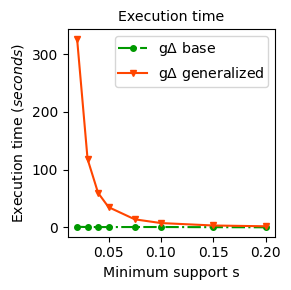

In [11]:
from utils_plot import plotDicts

input_dict = result_time
info_i = "time"
ylabel ="Execution time $(seconds)$"
title = 'Execution time'


info_plot = {}
for sup in input_dict.keys():
    for type_gen in input_dict[sup]:
        type_gen_str = abbreviateValue(f"{type_criterion}_{type_gen}", abbreviations)
        if type_gen_str not in info_plot:
            info_plot[type_gen_str] = {}
        info_plot[type_gen_str][float(sup)] = input_dict[sup][type_gen]
    
for type_gen_str in info_plot:
    info_plot[type_gen_str] = dict(sorted(info_plot[type_gen_str].items()))
        
size_fig = (3,3)



figure_name = os.path.join(output_fig_dir, f"{dataset_name}_stree_{min_support_tree}_{metric}_{info_i}.pdf")




plotDicts(info_plot, marker=True, \
          title=title, sizeFig=size_fig,\
                   linestyle=lines_style, color_labels=color_labels, \
          xlabel="Minimum support s",  ylabel=ylabel, labelSize=10.2,\
         outside=False,  saveFig=True, nameFig = figure_name, legendSize=10.2)

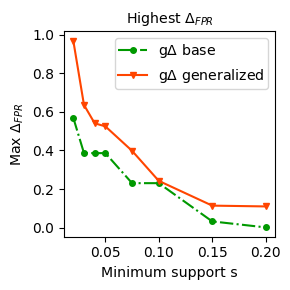

In [12]:
from utils_plot import plotDicts

input_dict = result_maxdiv
info_i = "time"
ylabel = 'Max $\\Delta_{FPR}$'
title = 'Highest $\\Delta_{FPR}$'


info_plot = {}
for sup in input_dict.keys():
    for type_gen in input_dict[sup]:
        type_gen_str = abbreviateValue(f"{type_criterion}_{type_gen}", abbreviations)
        if type_gen_str not in info_plot:
            info_plot[type_gen_str] = {}
        info_plot[type_gen_str][float(sup)] = input_dict[sup][type_gen]
    
for type_gen_str in info_plot:
    info_plot[type_gen_str] = dict(sorted(info_plot[type_gen_str].items()))
        
size_fig = (3,3)



figure_name = os.path.join(output_fig_dir, f"{dataset_name}_stree_{min_support_tree}_{metric}_{info_i}.pdf")




plotDicts(info_plot, marker=True, \
          title=title, sizeFig=size_fig,\
                   linestyle=lines_style, color_labels=color_labels, \
          xlabel="Minimum support s",  ylabel=ylabel, labelSize=10.2,\
         outside=False,  saveFig=True, nameFig = figure_name, legendSize=10.2)